In [ ]:
import relay_bp
from joblib import Parallel, delayed
import numpy as np
import stim
import matplotlib.pyplot as plt
from quits.decoder import detector_error_model_to_matrix 
from ldpc import BpDecoder  #belief propagation decoder
import sinter
import multiprocessing
from relay_bp.stim import sinter_decoders
import sys
from pathlib import Path
sys.path.append(str(Path("tests").resolve()))
from relay.tests.testdata import filter_detectors_by_basis, get_test_circuit
from relay_bp.stim import sinter_decoders



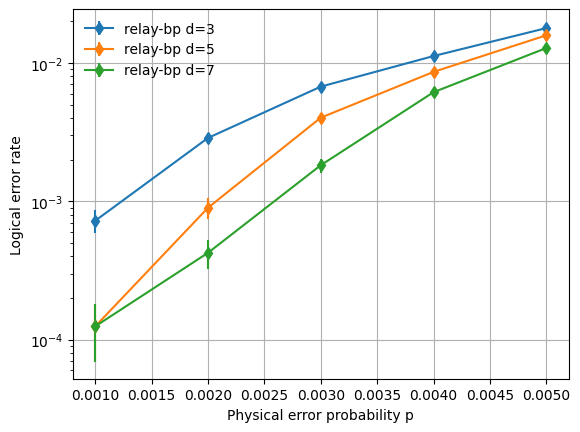

In [3]:
#Test the relay-BP on surface code

def decode_rotated_SC(num_shots):
    pvals = np.linspace(1e-3, 5e-3, 5)

    #--------- Run the relay-BP part ------------------------
    
    num_workers = multiprocessing.cpu_count()

    shots = num_shots
    XYZ_decoding = False    

    ds=[3,5,7]
    all_LER_relay = []
    for d in ds:
        LER_relay = []
        for p in pvals:

            decoders = sinter_decoders(
                gamma0=0.1,
                pre_iter=80,
                num_sets=60,
                set_max_iter=60,
                gamma_dist_interval=(-0.24, 0.66),
                stop_nconv=1,
            )

            
            circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                rounds=d,
                distance=d,
                after_clifford_depolarization=p,
                after_reset_flip_probability=p,
                before_measure_flip_probability=p,
                before_round_data_depolarization=p
            )        
            
            if not XYZ_decoding:
                circuit = filter_detectors_by_basis(circuit, "Z")

            task = sinter.Task(
                circuit=circuit,
                decoder="relay-bp",
                collection_options=sinter.CollectionOptions(max_shots=shots)
            )

            # Collect the samples (takes a few minutes).
            samples = sinter.collect(
                    tasks=[task],
                    num_workers=num_workers,
                    custom_decoders=decoders,
            )

            task_output = samples[0]
            # print("time (s): ",task_output.seconds)
            LER_relay.append(task_output.errors/task_output.shots)

        all_LER_relay.append(LER_relay)

    for k in range(len(all_LER_relay)):
        
        err = []
        for val in all_LER_relay[k]:
            err.append(np.sqrt(val*(1-val)/num_shots))

        plt.errorbar(pvals,all_LER_relay[k],yerr=err,marker='d',label=f'relay-bp d={ds[k]}')

    plt.xlabel("Physical error probability p")
    plt.ylabel("Logical error rate")
    plt.grid(True)
    plt.yscale('log')
    plt.legend(frameon=False)
    plt.show()

    return 

num_shots = 40_000
decode_rotated_SC(num_shots)    


---- Running d=3, p=0.004 ----------
---- Running d=3, p=0.003 ----------
---- Running d=5, p=0.003 ----------
---- Running d=3, p=0.005 ----------
---- Running d=5, p=0.001 ----------
---- Running d=5, p=0.002 ----------
---- Running d=3, p=0.002 ----------
---- Running d=3, p=0.001 ----------
---- Running d=5, p=0.004 ----------
---- Running d=5, p=0.005 ----------


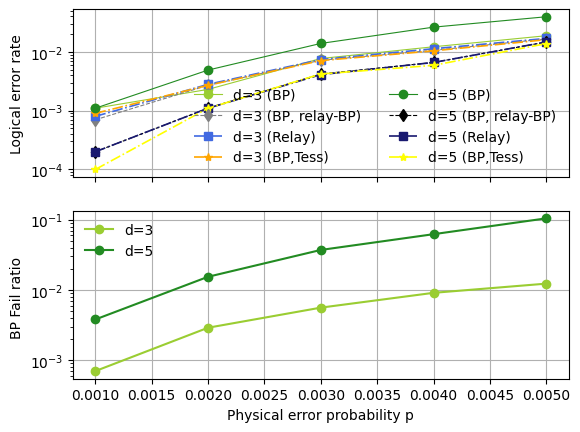

In [7]:
#Here use BP as a first decoder, and when H * e_perd != syndrome, switch to another decoder
#Could follow a different procedure, where we check if we reduce the weight of the error with BP and then switch to another decoder

from tesseract_decoder import tesseract


def get_circuit(p,d):

    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=d,
        distance=d,
        after_clifford_depolarization=p,
        after_reset_flip_probability=p,
        before_measure_flip_probability=p,
        before_round_data_depolarization=p)
    
    return circuit


def decode_w_relay_BP(circuit,XYZ_decoding,detection_event,obs_flip):

    if not XYZ_decoding:
        circuit = filter_detectors_by_basis(circuit, "Z")

    DEM = circuit.detector_error_model()
    detector_error_matrix, observables_matrix, priors =detector_error_model_to_matrix(DEM)

    decoder = relay_bp.RelayDecoderF64(
        detector_error_matrix,
        error_priors=priors, # Set the priors probability for each error
        gamma0=0.1, # Uniform memory weight for the first ensemble
        pre_iter=80, # Max BP iterations for the first ensemble
        num_sets=60, # Number of relay ensemble elements
        gamma_dist_interval=(-0.24, 0.66), # Set the uniform distribution range for disordered memory weight selection
        stop_nconv=1, # Number of relay solutions to find before stopping (the best will be selected)
    )

    prediction = decoder.decode(np.array(detection_event,dtype=np.uint8))
    predicted_log_flip = observables_matrix@ prediction % 2

    if not np.array_equal(predicted_log_flip, obs_flip):
        return 1
    else:
        return 0

def decode_w_tesseract(dem,detection_event,obs_flip):

    config = tesseract.TesseractConfig(dem=dem, det_beam=50) #The second argument controls accuracy/speed

    decoder = config.compile_decoder()

    flipped_observables = decoder.decode(detection_event)

    if not np.array_equal(flipped_observables, obs_flip):

        return 1
    else:
        return 0


def run_single_dp(d, p, num_shots, max_BP_iter):

    XYZ_decoding = False
    print(f"---- Running d={d}, p={p} ----------")

    circuit = get_circuit(p, d)
    if not XYZ_decoding:
        circuit = filter_detectors_by_basis(circuit, "Z")    
    DEM = circuit.detector_error_model()

    detector_error_matrix, observables_matrix, priors = detector_error_model_to_matrix(DEM)

    bp = BpDecoder(
        detector_error_matrix,
        channel_probs=priors,
        max_iter=max_BP_iter,
        bp_method="product_sum",
        schedule="serial", )

    sampler = circuit.compile_detector_sampler()
    detection_events, obs_flips = sampler.sample( shots=num_shots, separate_observables=True )

    num_errors_BP_only     = 0  #number of errors for BP only 
    num_errors_relay_only  = 0  #number of errors for relay-BP only 
    num_fails_BP           = 0  #number of times BP cannot produce the syndrome
    num_errors_BP_relay_BP = 0  #number of errors for BP+relay_BP
    num_errors_BP_tess     = 0  #number of errors for BP+tesseract

    
    for k in range(num_shots):

        prediction = bp.decode(detection_events[k, :])
        predicted_logicals_flipped = (observables_matrix @ prediction) % 2

        bp_logical_error = not np.array_equal(predicted_logicals_flipped, obs_flips[k, :])

        if bp_logical_error:
            num_errors_BP_only += 1

        syndrome_reconstr = (detector_error_matrix @ prediction ) % 2

        syndrome_ok = np.array_equal(syndrome_reconstr, detection_events[k, :])

        if syndrome_ok: #keep the BP result
            if bp_logical_error:
                num_errors_BP_relay_BP+=1
                num_errors_BP_tess+=1
        else:
            num_fails_BP+=1
            #use relay or tesseract
            num_errors_BP_relay_BP += decode_w_relay_BP(circuit,XYZ_decoding,detection_events[k, :],obs_flips[k, :])
            num_errors_BP_tess     += decode_w_tesseract(DEM,detection_events[k, :],obs_flips[k,:])

        num_errors_relay_only += decode_w_relay_BP(circuit,XYZ_decoding,detection_events[k, :],obs_flips[k, :]) 
        
    LER_BP_tess     =  num_errors_BP_tess/num_shots #this is 2-stage
    LER_BP_relay_BP = num_errors_BP_relay_BP/num_shots #this is 2-stage
    LER_Relay       = num_errors_relay_only/num_shots
    LER_BP          = num_errors_BP_only / num_shots
    BP_FAIL_RATIO   = num_fails_BP / num_shots
    

    return d, p, LER_BP, BP_FAIL_RATIO, LER_BP_relay_BP,LER_Relay, LER_BP_tess

def run_parallel(ds, pvals, num_shots, max_BP_iter, n_jobs=-1):

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(run_single_dp)(d, p, num_shots, max_BP_iter)
        for d in ds
        for p in pvals
    )

    res_dict = {
        (d, p): (ler_bp, fail_bp, ler_bp_relay_bp, ler_relay, lER_bp_tess)
        for d, p, ler_bp, fail_bp, ler_bp_relay_bp, ler_relay, lER_bp_tess in results
    }

    all_LER_BP = []
    all_BP_FAIL_RATIO = []
    all_LER_BP_Relay_BP = []
    all_LER_Relay = []
    all_LER_BP_Tess = []

    for d in ds:
        LER_BP = []
        BP_FAIL_RATIO = []
        LER_BP_Relay_BP = []
        LER_Relay = []
        LER_BP_Tess = []

        for p in pvals:
            ler_bp, fail_bp, ler_bp_relay_bp, ler_relay, lER_bp_tess = res_dict[(d, p)]
            LER_BP.append(ler_bp)
            BP_FAIL_RATIO.append(fail_bp)
            LER_BP_Relay_BP.append(ler_bp_relay_bp)
            LER_Relay.append(ler_relay)
            LER_BP_Tess.append(lER_bp_tess)

        all_LER_BP.append(LER_BP)
        all_BP_FAIL_RATIO.append(BP_FAIL_RATIO)
        all_LER_BP_Relay_BP.append(LER_BP_Relay_BP)
        all_LER_Relay.append(LER_Relay)
        all_LER_BP_Tess.append(LER_BP_Tess)

    LERS = {"BP": all_LER_BP, "BP+Relay-BP": all_LER_BP_Relay_BP, "Relay-BP":all_LER_Relay, "BP+Tess":all_LER_BP_Tess}

    return LERS, all_BP_FAIL_RATIO


def switching_BP_to_relay_BP(num_shots, max_BP_iter ):

    pvals = np.linspace(1e-3,5e-3,5)
    ds    = [3,5,]

    LERS, all_BP_FAIL_RATIO = run_parallel(
        ds,
        pvals,
        num_shots,
        max_BP_iter,
        n_jobs = -1,
    )


    fig,ax = plt.subplots(2, 1, sharex=True, )


    colors_BP    = ['yellowgreen','forestgreen']
    colors_TS    = ['gray','black']
    colors_TESS  = ['orange','yellow']
    colors_Relay = ['royalblue','midnightblue']
    
    #BP only result
    for k in range(len(ds)):
        ax[0].plot(pvals,LERS["BP"][k],marker='o',label=f'd={ds[k]} (BP)',color=colors_BP[k],linewidth=0.8)
        ax[0].plot(pvals,LERS["BP+Relay-BP"][k],marker='d',label=f'd={ds[k]} (BP, relay-BP)',color=colors_TS[k],linestyle='--',linewidth=0.8)
        ax[0].plot(pvals,LERS["Relay-BP"][k],marker='s',label=f'd={ds[k]} (Relay)',color=colors_Relay[k],linestyle='-.',linewidth=1.2)
        ax[0].plot(pvals,LERS["BP+Tess"][k],marker='*',label=f'd={ds[k]} (BP,Tess)',color=colors_TESS[k],linestyle='-.',linewidth=1.2)
        

    ax[0].set_ylabel("Logical error rate")
    ax[0].grid(True)
    ax[0].set_yscale('log')

    
    ax[0].legend(frameon=False,ncols=2)

    for k in range(len(all_BP_FAIL_RATIO)):
        ax[1].plot(pvals,all_BP_FAIL_RATIO[k],marker='o',label=f'd={ds[k]}',color=colors_BP[k])

    ax[1].set_ylabel("BP Fail ratio ")
    ax[1].set_xlabel("Physical error probability p")
    ax[1].set_yscale('log')
    ax[1].grid(True)

    plt.axis('tight')
    plt.legend(frameon=False)

    
    fig.savefig(f"test_shots_{num_shots}.pdf",bbox_inches='tight')
    plt.show()

    return 

num_shots   = 10_000
max_BP_iter = 5
switching_BP_to_relay_BP(num_shots, max_BP_iter)